In [ ]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1"

In [2]:
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

In [3]:
# embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
# filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
# gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
# plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/noise1' # needs to change...
# ckpt_idx = -1 # which GNN checkpoint to load
# dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
# min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
# frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching
# evtid = 1000
# event_file = os.path.join(utils_dir.inputdir, 'event{:09}'.format(evtid))

In [4]:
action = 'build'

config_file = pkg_resources.resource_filename(
                    "exatrkx",
                    os.path.join('configs', config_dict[action]))
with open(config_file) as f:
    b_config = yaml.load(f, Loader=yaml.FullLoader)
    
pp = pprint.PrettyPrinter(indent=4)

In [5]:
b_config['pt_min'] = 0
b_config['endcaps'] = True
b_config['n_workers'] = 1
b_config['n_files'] = 1
b_config['noise'] = 1
pp.pprint(b_config)

{   'adjacent': True,
    'cell_information': True,
    'endcaps': True,
    'layerless': True,
    'layerwise': False,
    'n_files': 1,
    'n_tasks': 1,
    'n_workers': 1,
    'noise': 1,
    'pt_min': 0}


In [6]:
# this cell is only needed for the first run to prodcue the dataset
preprocess_dm = FeatureStore(b_config)
preprocess_dm.prepare_data()

Loading detector...
Detector loaded.
Writing outputs to /global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store
Preparing 1000
adding 1% noise
Layerless truth graph built for /global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000 with size (2, 6455778)
Cell features for 1000
Loading event /global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000 with a 0 pT cut
Writing to  /global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/1000


In [7]:
def plot_noise_dist(noise_keeps):
    noise = []
    not_noise = []
    for i in noise_keeps:
        data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/1000"
        #data = torch.load(f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/feature_store_endcaps/n{i}/1000")
        data = torch.load(data_path)
        arr = data['pid']
        n_count = np.count_nonzero(arr==0)
        not_n = np.count_nonzero(arr)
        noise.append(n_count)
        not_noise.append(not_n)
        print("-----")
        print(data)

    x = np.arange(len(noise_keeps))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,5))
    rects1 = ax.bar(x - width/2, noise, width, label='noise')
    rects2 = ax.bar(x + width/2, not_noise, width, label='not noise')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('# of hits')
    ax.set_xlabel('keep')
    ax.set_xticks(x)
    labels = noise_keeps
    ax.set_xticklabels(labels)
    ax.legend()
    
    fig2, ax2 = plt.subplots(figsize=(10,5))
    ax2.plot(x,noise, label='noise')
    ax2.set_ylabel('# of hits')
    ax2.set_xlabel('keep')
    ax2.set_xticks(x)
    labels = noise_keeps
    ax2.set_xticklabels(labels)
    ax2.legend()
    
    fig3, ax3 = plt.subplots(figsize=(10,5))
    ax3.plot(x,not_noise, label='not noise')
    ax3.set_ylabel('# of hits')
    ax3.set_xlabel('keep')
    ax3.set_xticks(x)
    labels = noise_keeps
    ax3.set_xticklabels(labels)
    ax3.legend()

-----
Data(cell_data=[103305, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[103305], layerless_true_edges=[2, 6455778], layers=[120939], pid=[103305], x=[103305, 3])
-----
Data(cell_data=[106831, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[106831], layerless_true_edges=[2, 6455778], layers=[120939], pid=[106831], x=[106831, 3])
-----
Data(cell_data=[110358, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[110358], layerless_true_edges=[2, 6455778], layers=[120939], pid=[110358], x=[110358, 3])
-----
Data(cell_data=[113885, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[113885], layerless_true_edges=[2, 6455778], layers=[120939], pid=[113885], x=[113885, 3])
-----
Data(cell_data=[117412, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[117412], layerl

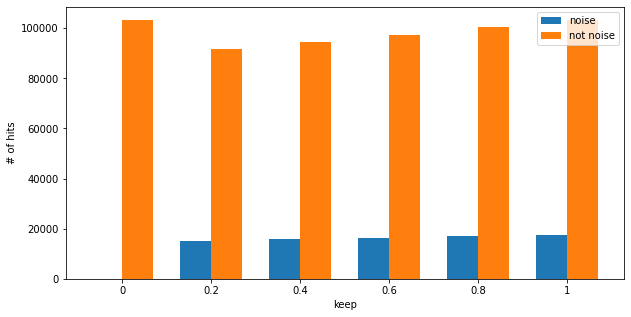

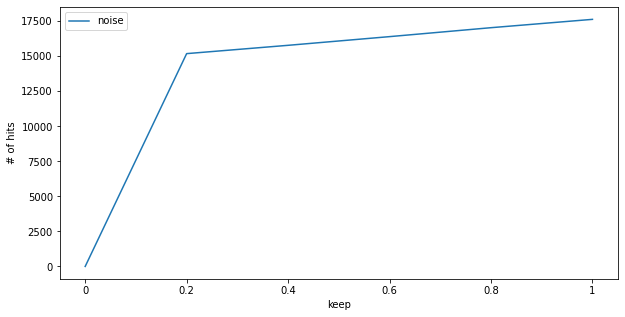

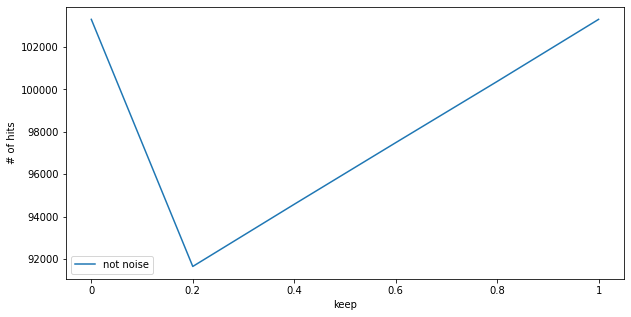

In [8]:
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
#  "0.4", "0.6", "0.8", "1"
plot_noise_dist(noise_keep)

In [9]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run' # needs to change...

In [10]:
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

In [11]:
emb_ckpt = torch.load(embed_ckpt_dir, map_location='cpu')
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']['knn_val'] = 500
emb_ckpt['hyper_parameters']['r_val'] = 1.7
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"knn_val":        500
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          1.7
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [12]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])
emb_model.load_state_dict(emb_ckpt["state_dict"])

<All keys matched successfully>

In [13]:
emb_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

In [14]:
%%time
p_all = []
e_all = []
for i in noise_keep:
    data_path = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/1000'
    p, e = get_emb_metrics(data_path, emb_model)
    p_all.append(p)
    e_all.append(e)

-----------
cluster true = 6455778
cluste true positive = 17850
cluster positive = 10048704
purity = 0.0017763484724000228
efficiency = 0.0027649649662674276
-----------
cluster true = 6455778
cluste true positive = 22269
cluster positive = 12208803
purity = 0.0018240117397258354
efficiency = 0.0034494680579164896
-----------
cluster true = 6455778
cluste true positive = 24284
cluster positive = 12785424
purity = 0.0018993503852512048
efficiency = 0.003761591554108583
-----------
cluster true = 6455778
cluste true positive = 26059
cluster positive = 13387094
purity = 0.001946576307001355
efficiency = 0.004036539050754223
-----------
cluster true = 6455778
cluste true positive = 27330
cluster positive = 13991138
purity = 0.0019533793462690454
efficiency = 0.004233416948352314
-----------
cluster true = 6455778
cluste true positive = 191170
cluster positive = 14602293
purity = 0.013091779489700693
efficiency = 0.02961223263873076
CPU times: user 47 s, sys: 20.6 s, total: 1min 7s
Wall tim

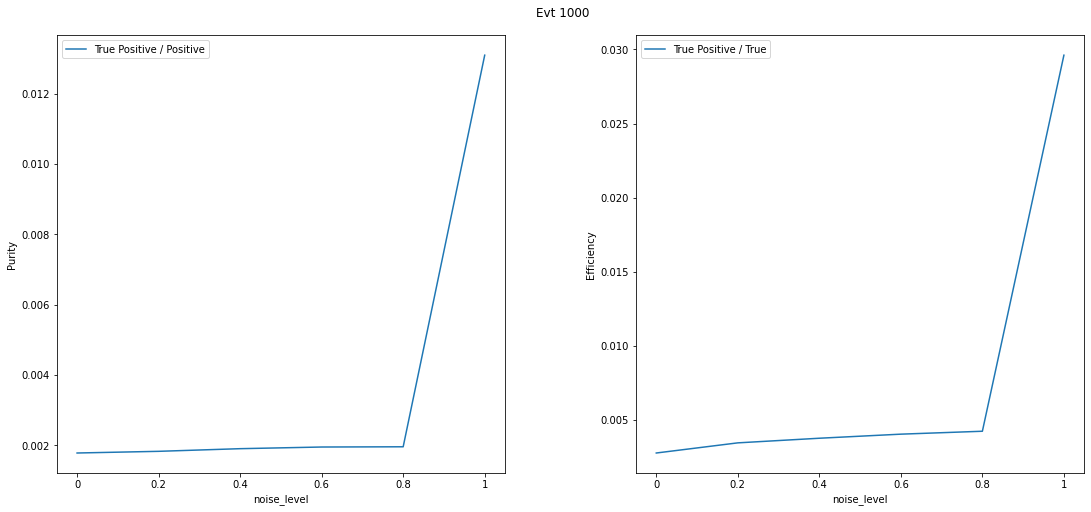

In [15]:
x = np.arange(len(noise_keep))
fig1, (ax11,ax22) = plt.subplots(1,2, figsize=(15,7))
fig1.suptitle('Evt 1000')
fig1.tight_layout(w_pad = 10)
ax11.plot(x, p_all, label = 'True Positive / Positive')
ax11.set_xlabel('noise_level')
ax11.set_ylabel('Purity')
ax11.set_xticks(x)
ax11.set_xticklabels(noise_keep)
ax11.legend()

ax22.plot(x, e_all, label = 'True Positive / True')
ax22.set_xlabel('noise_level')
ax22.set_ylabel('Efficiency')
ax22.set_xticks(x)
ax22.set_xticklabels(noise_keep)
ax22.legend()